In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def import_and_select(calibration_folder, data_folder, run_n):
    pedestals, mips, run=import_data(calibration_folder, data_folder, run_n)
    run=select_events(run, pedestals)
    return run

In [29]:
def drop_columns(df):
    kept_columns=['layer', 'strip', 'pedestal', 'pf_event', 'adc_sum_end0', 'adc_sum_end1', 'end', 'mpv', 'std_dev']
    df=df[df.columns.intersection(kept_columns)]
    return df

In [4]:
def import_data(calibration_folder, data_folder, run_n):
    pedestals=drop_columns(pd.read_csv(calibration_folder+"/pedestals.csv", sep=','))
    mips=drop_columns(pd.read_csv(calibration_folder+"/mip.csv", sep=','))
    run=drop_columns(pd.read_csv(data_folder+"/run_"+str(run_n)+".csv", sep=','))
    return pedestals,mips,run

In [5]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [6]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [44]:
#uses the 1.2x pedestal criteria to remove "false" events. essentially cut 0
#I don't think it should have a switch here for other methods - somewhere else there needs to be one though!
def confirm_events(df, pedestals):
    # can probably get rid of the loop, but then we would have to split the main df to have ends in different rows. annoying.
    confirmed_data=[]
    layers=np.arange(1,20)
    strips=np.arange(0,12)
    for layer in layers:
        for strip in strips:
            df_slice=choose_bar(df,layer,strip)
            pedestal_slice=choose_bar(pedestals,layer,strip)
            if not pedestal_slice.empty:
                df_slice=df_slice[df_slice["adc_sum_end0"]>1.2*pedestal_slice.iloc[0,-2]] # there could be a switch whether we want to
                df_slice=df_slice[df_slice["adc_sum_end1"]>1.2*pedestal_slice.iloc[1,-2]] # require both ends to register the hit
            confirmed_data.extend(df_slice.values.tolist())
    confirmed_df=pd.DataFrame(confirmed_data, columns=['event', 'adc_sum_end0', 'layer', 'strip', 'adc_sum_end1'])
    events_left=confirmed_df.event.unique()
    print("Initial pedestal-based selection performed.")
    print("Events left: "+str(len(events_left)))
    print("\n")
    return confirmed_df

In [33]:
def confirm_events_sigma(df, pedestals):
    # signal defined as anything above pedestal+5*pedestal std_dev
    confirmed_data=[]
    layers=np.arange(1,20)
    strips=np.arange(0,12)
    for layer in layers:
        for strip in strips:
            df_slice=choose_bar(df,layer,strip)
            pedestal_slice=choose_bar(pedestals,layer,strip)
            if not pedestal_slice.empty:
                df_slice=df_slice[df_slice["adc_sum_end0"]>(pedestal_slice.iloc[0,-2]+5*pedestal_slice.iloc[0,-1])] # there could be a switch whether we want to
                df_slice=df_slice[df_slice["adc_sum_end1"]>(pedestal_slice.iloc[1,-2]+5*pedestal_slice.iloc[0,-1])] # require both ends to register the hit
            confirmed_data.extend(df_slice.values.tolist())
    confirmed_df=pd.DataFrame(confirmed_data, columns=['event', 'adc_sum_end0', 'layer', 'strip', 'adc_sum_end1'])
    events_left=confirmed_df.event.unique()
    print("Initial pedestal-based selection performed.")
    print("Events left: "+str(len(events_left)))
    print("\n")
    return confirmed_df

In [34]:
def first_layer_cut(df):
    helper_df=df[df['layer']==1].groupby(['event']).count()
    events_to_remove=helper_df[helper_df['layer']>1].index.values.tolist()
    df=df[~df['event'].isin(events_to_remove)]
    
    events_left=df.event.unique()
    print("Events with multiple hits in first layer removed.")
    print("Events left: "+str(len(events_left)))
    print("\n")
    return df

In [9]:
def back_layer_cut(df, b_num):
    events_to_remove=df[df['layer']>19-b_num].groupby(['event']).count().index.values.tolist()
    df=df[~df['event'].isin(events_to_remove)]
    
    events_left=df.event.unique()
    print("Events with hits in the back " +str(b_num)+" layers removed.")
    print("Events left: "+str(len(events_left)))
    print("\n")
    return df

In [10]:
def select_events(df,pedestals,cut_first_layer=True, cut_back_layers=True, back_layers=5):
    print("Number of events: "+str(len(df.pf_event.unique())))
    print("\n")
    df=confirm_events(df, pedestals)
    if cut_first_layer==True:
        df=first_layer_cut(df)
    if cut_back_layers==True:
        df=back_layer_cut(df,back_layers)
    return df

In [11]:
c_folder="../../data/calibration"
d_folder="../../data/runData"
r_n=300

In [64]:
%%time
p,m,r=import_data(c_folder,d_folder,r_n)
r=confirm_events(r,p)
#r=first_layer_cut(r)
#r=back_layer_cut(r,7)

Initial pedestal-based selection performed.
Events left: 71414


CPU times: user 24 s, sys: 2.53 s, total: 26.5 s
Wall time: 26.7 s


In [65]:
layer_energy=r.groupby(["layer"]).sum().drop(columns=["event", "strip"]).reset_index()

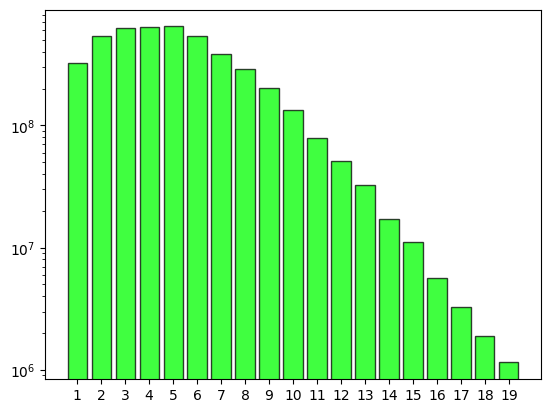

In [73]:
plt.bar(layer_energy['layer'], (layer_energy["adc_sum_end0"]+layer_energy["adc_sum_end1"])/(2), 
        color='lime', alpha=0.75, edgecolor="black", label="Run 300")
plt.yscale('log')
plt.xticks(np.arange(1,20))
plt.show()

In [60]:
#not_funky=r[r["layer"].isin([13,14])].event.unique()

In [59]:
#r[~r["event"].isin(not_funky)]

In [63]:
r[r["event"]==46571]

,event,adc_sum_end0,layer,strip,adc_sum_end1
40236,46571,8025,1,3,8111
145180,46571,5338,2,3,5366
194971,46571,1599,2,4,1724
226944,46571,1413,3,2,1627
275263,46571,6544,3,3,5823
432631,46571,4475,4,3,3874
495094,46571,3159,4,4,3006
561064,46571,1358,5,2,1488
617091,46571,4949,5,3,4920
757464,46571,1485,6,2,1411


In [74]:
# 20 000 at 1.3*pedestal
# 25 000 at 1.2*pedestal
p

,layer,strip,end,pedestal,std_dev
0,1,0,0,760,9.674627
1,1,0,1,840,11.046368
2,1,1,0,760,14.564194
3,1,1,1,760,18.856047
4,1,2,0,728,10.387670
...,...,...,...,...,...
379,19,9,1,824,9.375246
380,19,10,0,728,9.138480
381,19,10,1,824,9.243012
382,19,11,0,792,11.286028
